In [1]:
import os

from pathlib import Path

import matplotlib.pyplot as plt

from lhotse.cut import CutSet
from lhotse.dataset.speech_synthesis import SpeechSynthesisDataset
from lhotse.features import FeatureSetBuilder
from lhotse.recipes.ljspeech import download_and_untar, prepare_ljspeech, feature_extractor, text_normalizer

# Settings for paths

In [2]:
root_dir = Path('data')
corpus_dir = root_dir / 'LJSpeech-1.1'
output_dir = root_dir / 'ljspeech_nb'

# Download and untar

In [3]:
download_and_untar(root_dir)

# Prepare audio and supervision manifests

In [4]:
ljspeech_manifests = prepare_ljspeech(corpus_dir, output_dir)

# Extract features

In [5]:
feature_set_builder = FeatureSetBuilder(
    feature_extractor=feature_extractor(),
    output_dir=f'{output_dir}/feats'
)
feature_set = feature_set_builder.process_and_store_recordings(
    recordings=ljspeech_manifests['audio'],
    num_jobs=os.cpu_count()
)
ljspeech_manifests['feats'] = feature_set

cut_set = CutSet.from_manifests(supervisions=ljspeech_manifests['supervisions'],
                                features=ljspeech_manifests['feats'],
                                recordings=ljspeech_manifests['audio'])

# Text normalization

A simple text normalizer is provided in `lhotse.recipes.ljspeech`:

```python
from lhotse.utils import fastcopy

def text_normalizer(segment: SupervisionSegment) -> SupervisionSegment:
    text = segment.text.upper()
    text = re.sub(r'[^\w !?]', '', text)
    text = re.sub(r'^\s+', '', text)
    text = re.sub(r'\s+$', '', text)
    text = re.sub(r'\s+', ' ', text)
    return fastcopy(segment, text=text)
```

You may want to replace the default TN with you own codes. If so, write a "SupervisionSegment -> SupervisionSegment" function and put it as the argument of the `map_supervisions` function.

In [6]:
cut_set = cut_set.map_supervisions(text_normalizer)

cut_set.to_json(output_dir / f'cuts.json.gz')
ljspeech_manifests['cuts'] = cut_set

# Make pytorch Dataset

In [7]:
cuts_train = SpeechSynthesisDataset(ljspeech_manifests['cuts'])

## Token set

In [8]:
print(cuts_train.vocabulary)

[' ', '!', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# Illustation of an example

In [9]:
sample = cuts_train[0]

## Tokens

In [10]:
print(sample['tokens'])

['I', 'N', ' ', '1', '8', '1', '3']


## Features

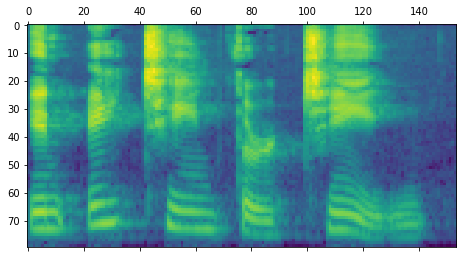

In [11]:
plt.matshow(sample['features'].transpose(0, 1).flip(0))

## Audios (for neural vocoder)

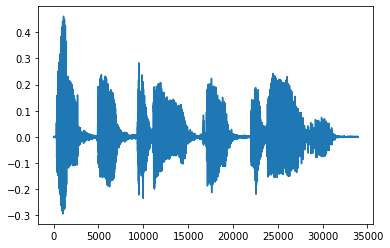

In [13]:
plt.plot(sample['audio'].transpose(0, 1))